In [1]:
import os
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt
from pulse2percept.implants import ArgusII, ProsthesisSystem, ElectrodeGrid, DiskElectrode
from pulse2percept.models import Model, ScoreboardModel, AxonMapModel
from pulse2percept.viz import plot_implant_on_axon_map
import torch
from torchvision import datasets, transforms
from multiprocessing import cpu_count, Pool
import parmap
from skimage.transform import resize

In [2]:
%matplotlib inline

In [4]:
def create_implant(e_num_side, e_radius, spacing=None, total_area=None, plot = True):
    if total_area is not None:
        spacing = total_area/(e_num_side - 1)
    elif spacing is None:
        print("ERROR: Provide a spacing or total_area parameter in microns")

        return

    implant = ProsthesisSystem(ElectrodeGrid((e_num_side, e_num_side), spacing=spacing, etype=DiskElectrode, r=e_radius))

    if plot:
        plot_implant_on_axon_map(implant, annotate_implant=False)

    return implant

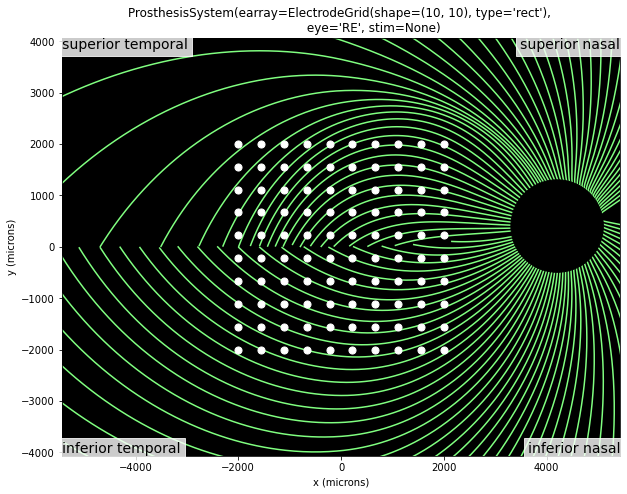

In [5]:
custom_implant  = create_implant(e_num_side=10, e_radius=50, total_area=4000, plot=True)
ArgusII_implant = ArgusII()

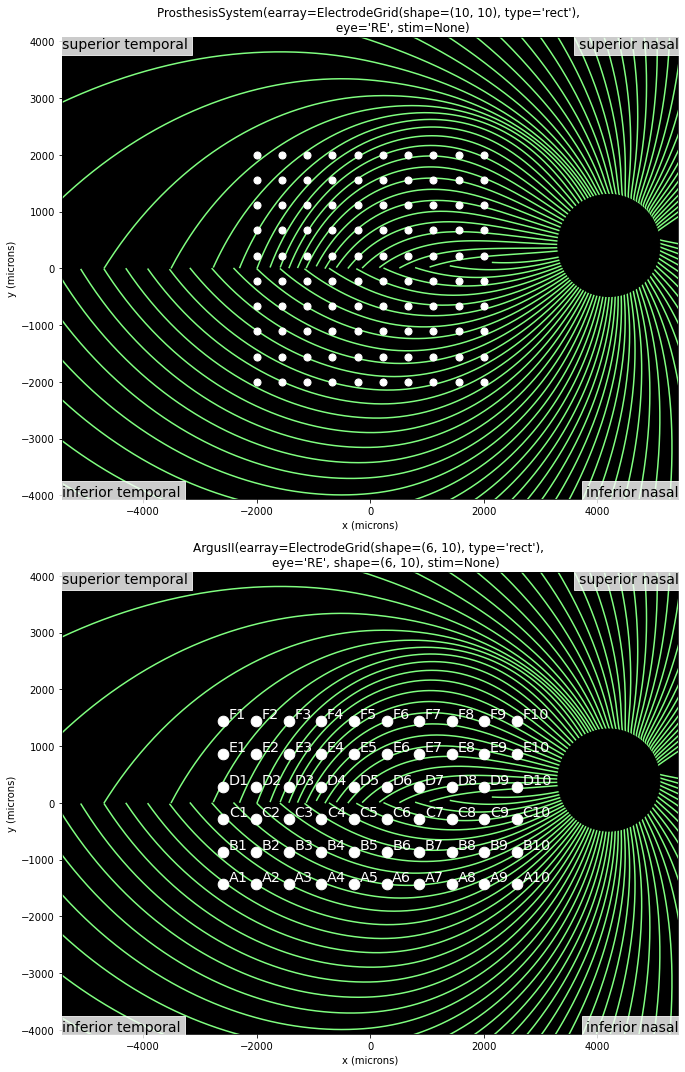

In [6]:
fig  = plt.figure(figsize=(20, 15))
axes = [fig.add_subplot(211),
        fig.add_subplot(212)]

plot_implant_on_axon_map(custom_implant,  ax = axes[0], annotate_implant=False, annotate_quadrants=True)
plot_implant_on_axon_map(ArgusII_implant, ax = axes[1], annotate_implant=True,  annotate_quadrants=True)

fig.tight_layout()

In [7]:
# Initialize models
axonMap_model    = AxonMapModel()
scoreBoard_model = ScoreboardModel()

# Build models
axonMap_model.build()
scoreBoard_model.build()

ScoreboardModel(engine='serial', grid_type='rectangular', 
                n_jobs=1, rho=100, scheduler='threading', 
                spatial=ScoreboardSpatial, temporal=None, 
                thresh_percept=0, verbose=True, 
                xrange=(-20, 20), xystep=0.25, 
                yrange=(-15, 15))

In [3]:
transform   = transforms.Compose([transforms.ToTensor()])

trainset    = datasets.MNIST('./data', download=True, train=True,  transform=transform)
testset     = datasets.MNIST('./data', download=True, train=False, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader  = torch.utils.data.DataLoader(testset,  batch_size=64, shuffle=True)

In [4]:
dataiter = iter(trainloader)
images, labels = dataiter.next()

print(images.shape)
print(labels.shape)

torch.Size([64, 1, 28, 28])
torch.Size([64])


In [7]:
images[index].numpy().squeeze()

array([[0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.],
       ...,
       [0., 0., ..., 0., 0.],
       [0., 0., ..., 0., 0.]], dtype=float32)

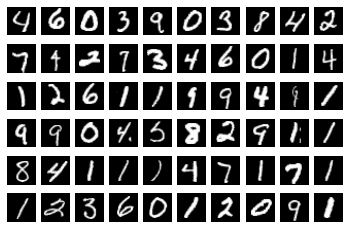

In [6]:
fig = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(images[index].numpy().squeeze(), cmap='gray')

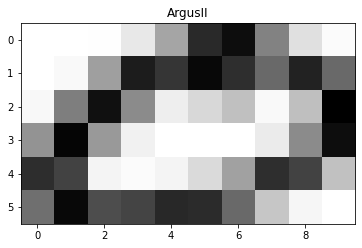

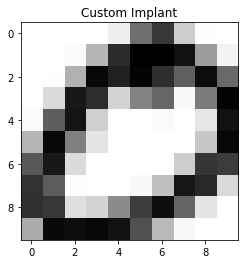

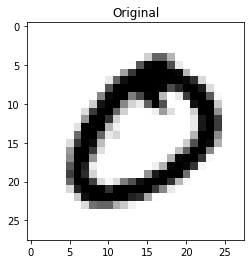

In [11]:
def img2stimwide(img, implant):
    npwhr = np.where(img > 0.05)

    ymin = min(npwhr[0])
    ymax = max(npwhr[0])
    xmin = min(npwhr[1])
    xmax = max(npwhr[1])

    if 2*(xmax - xmin) < (ymax-ymin):
        xmin = 0
        xmax = img.shape[1]

    return resize(img[ymin:ymax, xmin:xmax], implant.earray.shape).flatten()

plt.figure()
plt.title("ArgusII")
plt.imshow(np.reshape(img2stimwide(images[25].numpy().squeeze(), ArgusII_implant), ArgusII_implant.shape),
           cmap='gray_r')
plt.figure()
plt.title("Custom Implant")
plt.imshow(np.reshape(img2stimwide(images[25].numpy().squeeze(), custom_implant),  custom_implant.earray.shape),
           cmap='gray_r')
plt.figure()
plt.title("Original")
plt.imshow(images[25].numpy().squeeze(), cmap='gray_r')

In [12]:
def perc2training(percept, out_size):
    data  = percept.data.squeeze()
    npwhr = np.where(data > 0.01)

    ymin = min(npwhr[0])
    ymax = max(npwhr[0])
    xmin = min(npwhr[1])
    xmax = max(npwhr[1])

    return torch.from_numpy(resize(data[ymin:ymax, xmin:xmax], out_size))

In [13]:
def get_output_paths(implant_name):
    percept_path          = os.path.join('data', 'MNIST', 'percept', implant_name)
    percept_path_test     = os.path.join('data', 'MNIST', 'percept', implant_name, 'test')
    percept_path_training = os.path.join('data', 'MNIST', 'percept', implant_name, 'training')

    if not os.path.exists(percept_path):
        os.makedirs(percept_path)
    if not os.path.exists(percept_path_test):
        os.makedirs(percept_path_test)
    if not os.path.exists(percept_path_training):
        os.makedirs(percept_path_training)

    return percept_path, percept_path_test, percept_path_training

In [14]:
def get_subset(train_samples, test_samples, train_set, test_set):
    trainset = train_set.data.numpy()
    testset  = test_set.data.numpy()

    train_labels  = train_set.targets.numpy()
    test_labels   = test_set.targets.numpy()
    labels_number = len(np.unique(test_labels))

    train_samples_per_label = int(train_samples/labels_number)
    test_samples_per_label  = int(test_samples/labels_number)

    whr_train = np.concatenate([np.argwhere(train_labels==i).flatten()[:train_samples_per_label]
                                for i in range(labels_number)]).flatten()
    whr_test  = np.concatenate([np.argwhere(test_labels ==i).flatten()[:test_samples_per_label]
                                for i in range(labels_number)]).flatten()

    return ((trainset[whr_train], train_labels[whr_train]),
            (testset[ whr_test ], test_labels[ whr_test ]))

In [15]:
def get_zipped_args(dataset, dataset_path):
    all_files = os.listdir(os.path.abspath(dataset_path))
    excl_file_numbers = []

    if all_files is not None:
        ex_dataset_files  = list(filter(lambda file: file.endswith('.pt'), all_files))
        excl_file_numbers = [int(dataset_file.split('-')[0]) for dataset_file in ex_dataset_files]

    if type(dataset) == tuple:
        data   = dataset[0]
        labels = dataset[1]
    else:
        data   = dataset.data
        labels = dataset.targets

    return [[d, t.item(), i]
            for i, (d, t), in enumerate(zip(data, labels))
            if i not in excl_file_numbers
           ]

In [16]:
def get_implant_and_sample_to_simulate(trainset, testset, model, e_num_side=None, e_radius=None, spacing=None,
                                       total_area=None, ArgusII_implant=False, showResults=False):
    if ArgusII_implant is False and (e_num_side is None or e_radius is None or (spacing is None and total_area is None)):
        print("ERROR: You must provide e_num_side, e_radius and spacing parameters or set ArgusII_implant=True")

        return

    if ArgusII_implant:
        implant = ArgusII()
        implant_name = "ArgusII"
        if showResults:
            plot_implant_on_axon_map(implant)
    else:
        implant = create_implant(e_num_side=e_num_side, e_radius=e_radius, spacing=spacing,
                                 total_area=total_area, plot=showResults)
        implant_name = f"e_num_side={e_num_side}-e_radius={e_radius}-spacing={spacing}-total_area={total_area}"

    model_name = str(type(model)).split('.')[-1][:-2]
    percept_path, percept_path_test, percept_path_training = get_output_paths(model_name+'-'+implant_name)

    zipped_train_args = get_zipped_args(trainset, percept_path_training)
    zipped_test_args  = get_zipped_args(testset,  percept_path_test)

    if showResults:
        print(f"Number of train samples to simulate: {len(zipped_train_args)}")
        print(f"Number of test samples to simulate:  {len(zipped_test_args)}")

    return (implant, implant_name, model,
            zipped_train_args, zipped_test_args,
            percept_path, percept_path_test, percept_path_training)

In [17]:
subset_trainset, subset_testset = get_subset(2000, 400, trainset, testset)

Number of train samples to simulate: 2000
Number of test samples to simulate:  400


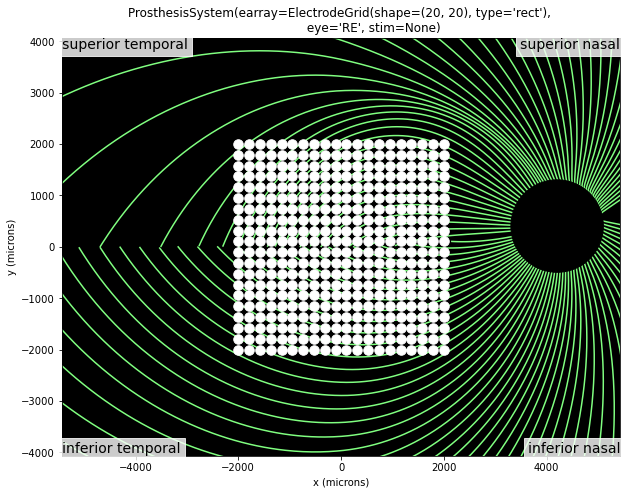

In [38]:
(implant, implant_name, model,
 zipped_train_args, zipped_test_args,
 percept_path, percept_path_test, percept_path_training)=get_implant_and_sample_to_simulate(subset_trainset,
                                                                                            subset_testset,
                                                                                            axonMap_model,
                                                                                            e_num_side=20,
                                                                                            e_radius=90,
                                                                                            spacing=None,
                                                                                            total_area=4000,
                                                                                            showResults=True)

In [105]:
def one_loop(img, label, idx, path):
    if type(img)==torch.Tensor:
        img = img.numpy().squeeze()

    implant.stim = img2stimwide(img, implant)
    percept = model.predict_percept(implant)
    img = perc2training(percept, (28, 28))
    torch.save(img, os.path.join(path, f'{idx}-{label}.pt'))

In [106]:
from multiprocessing import Pool
with Pool(processes = cpu_count()) as pool:
    parmap.starmap(one_loop, zipped_train_args, os.path.join(percept_path_training),
                   pm_pbar=True, pm_processes=cpu_count(), pm_chunksize=5)

100%|██████████| 2000/2000 [10:01<00:00,  3.32it/s]


In [107]:
with Pool(processes = cpu_count()) as pool:
    parmap.starmap(one_loop, zipped_test_args, os.path.join(percept_path_test),
                   pm_pbar=True, pm_processes=cpu_count(), pm_chunksize=5)

100%|██████████| 400/400 [02:07<00:00,  3.15it/s]


In [ ]:
# ArgusII_percept_train = torch.zeros(trainset.data.shape)
# for idx, img in enumerate(trainset.data):
#     print(idx)
#     implants['ArgusII'].stim = img2stim(img.numpy().squeeze(), implants['ArgusII'])
#     percept = model.predict_percept(implants['ArgusII'])
#     ArgusII_percept_train[idx] = perc2trainimg(percept, (28, 28))

# torch.save(ArgusII_percept_train, os.path.join(ArgusII_percept_path, 'training.pt'))

In [ ]:
# ArgusII_percept_test = torch.zeros(testset.data.shape)
# for idx, img in enumerate(testset.data):
#     print(idx)
#     implants['ArgusII'].stim = img2stim(img.numpy().squeeze(), implants['ArgusII'])
#     percept = model.predict_percept(implants['ArgusII'])
#     ArgusII_percept_test[idx] = perc2trainimg(percept, (28, 28))

# torch.save(ArgusII_percept_train, os.path.join(ArgusII_percept_path, 'test.pt'))